# Lecture 16: Class demo

## Imports

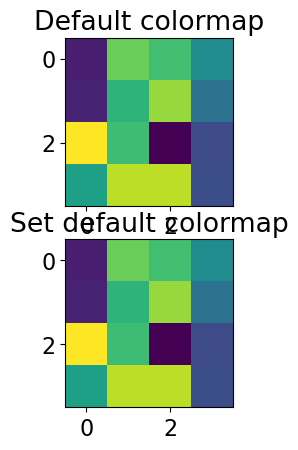

In [1]:
import os
import random
import sys
import time

import numpy as np
sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))

import matplotlib.pyplot as plt
from plotting_functions import *
from plotting_functions_unsup import *
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler

plt.rcParams["font.size"] = 16
import matplotlib.cm as cm

# plt.style.use("seaborn")
%matplotlib inline
pd.set_option("display.max_colwidth", 0)
DATA_DIR = os.path.join(os.path.abspath(".."),(".."), "data/")

<br><br>

### Creating utility matrix

Let's work with the following toy example. 

In [2]:
toy_ratings = pd.read_csv(DATA_DIR + "toy_ratings.csv")
toy_ratings

,user_id,movie_id,rating
0,Sam,Lion King,4
1,Sam,Jerry Maguire,4
2,Sam,Roman Holidays,5
3,Sam,Downfall,1
4,Eva,Titanic,2
5,Eva,Jerry Maguire,1
6,Eva,Inception,4
7,Eva,Man on Wire,5
8,Eva,The Social Dilemma,5
9,Pat,Titanic,3


In [3]:
user_key = "user_id"
item_key = "movie_id"

In [4]:
def get_stats(ratings, item_key="movie_id", user_key="user_id"):
    print("Number of ratings:", len(ratings))
    print("Average rating:  %0.3f" % (np.mean(ratings["rating"])))
    N = len(np.unique(ratings[user_key]))
    M = len(np.unique(ratings[item_key]))
    print("Number of users (N): %d" % N)
    print("Number of items (M): %d" % M)
    print("Fraction non-nan ratings: %0.3f" % (len(ratings) / (N * M)))
    return N, M


N, M = get_stats(toy_ratings)

Number of ratings: 21
Average rating:  3.524
Number of users (N): 4
Number of items (M): 12
Fraction non-nan ratings: 0.438


- Let's construct utility matrix with `number of users` rows and `number of items` columns from the ratings data. 
> Note we are constructing a non-sparse matrix for demonstration purpose here. In real life it's recommended that you work with sparse matrices. 

In [5]:
user_mapper = dict(zip(np.unique(toy_ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(toy_ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(toy_ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(toy_ratings[item_key])))

- Why do we need all these mappers? 
    - We want to store the rating for user $i$ and item $j$ at $Y[i,j]$ location in the utility matrix. 
    - So we define `user_mapper` and `item_mapper` which map user and item ids to indices. 
    - Once we have predicted ratings for users and items, we want to be able to map it to the original user and item ids so that we recommend the right product to the right user. 
    - So we have `user_inverse_mapper` and `item_inverse_mapper` which map indices to original user and item ids.        

In [6]:
user_key = "user_id"
item_key = "movie_id"
user_mapper = dict(zip(np.unique(toy_ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(toy_ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(toy_ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(toy_ratings[item_key])))

def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

In [7]:
Y_mat = create_Y_from_ratings(toy_ratings, N, M)
Y_mat.shape

(4, 12)

In [8]:
pd.DataFrame(Y_mat)

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,5.0,NaN,5.0,2.0
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,5.0,NaN,5.0,2.0
2,3.0,4.0,3.0,2.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN,3.0
3,NaN,NaN,NaN,1.0,NaN,4.0,4.0,NaN,NaN,5.0,NaN,NaN


In [9]:
Y = create_Y_from_ratings(toy_ratings, N, M)
utility_mat = pd.DataFrame(Y, columns=item_mapper.keys(), index=user_mapper.keys())
utility_mat

,A Beautiful Mind,Bambi,Cast Away,Downfall,Inception,Jerry Maguire,Lion King,Malcolm x,Man on Wire,Roman Holidays,The Social Dilemma,Titanic
Eva,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,5.0,NaN,5.0,2.0
Jim,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,5.0,NaN,5.0,2.0
Pat,3.0,4.0,3.0,2.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN,3.0
Sam,NaN,NaN,NaN,1.0,NaN,4.0,4.0,NaN,NaN,5.0,NaN,NaN


- Rows represent users.
- Columns represent items (movies in our case).
- Each cell gives the rating given by the user to the corresponding movie. 
- Users are features for movies and movies are features for users.
- Our goal is to predict missing entries in the utility matrix.

<br><br>

### Evaluation

- We'll try a number of methods to fill in the missing entries in the utility matrix.
- Although there is no notion of "accurate" recommendations, we need a way to evaluate our predictions so that we'll be able to compare different methods.
- Although we are doing unsupervised learning, we'll split the data and evaluate our predictions as follows.  

**Data splitting**

- We split the ratings into train and validation sets. 
- It's easier to split the ratings data instead of splitting the utility matrix.
- Don't worry about `y`; we're not really going to use it.  

In [10]:
X = toy_ratings.copy()
y = toy_ratings[user_key]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_valid.shape

((16, 3), (5, 3))

Now we will create utility matrices for train and validation splits. 

In [11]:
train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

In [12]:
train_mat.shape, valid_mat.shape

((4, 12), (4, 12))

In [13]:
(len(X_train) / (N * M)) # Fraction of non-nan entries in the train set

0.3333333333333333

In [14]:
(len(X_valid) / (N * M)) # Fraction of non-nan entries in the valid set

0.10416666666666667

In [15]:
pd.DataFrame(train_mat)

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,5.0,NaN,NaN,2.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,5.0,2.0
2,NaN,4.0,3.0,2.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN,3.0
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN


In [16]:
pd.DataFrame(valid_mat)

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
2,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN


- `train_mat` has only ratings from the train set and `valid_mat` has only ratings from the valid set.
- During training we assume that we do not have access to some of the available ratings. We predict these ratings and evaluate them against ratings in the validation set. 

### ❓❓ Questions for you


- How do train and validation utility matrices differ? 
- Why are utility matrices for train and validation sets are of the same shape?

<br><br><br><br>

- Now that we have train and validation sets, how do we evaluate our predictions?
- You can calculate the error between actual ratings and predicted ratings with metrics of your choice. 
    - Most common ones are MSE or RMSE. 

- The `error` function below calculates RMSE and `evaluate` function prints train and validation RMSE.
- Lower RMSE $\rightarrow$ predicted ratings are closer to the actual ratings

In [17]:
def error(X1, X2):
    """
    Returns the root mean squared error.
    """
    return np.sqrt(np.nanmean((X1 - X2) ** 2))


def evaluate(pred_X, train_X, valid_X, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_X, train_X)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_X, valid_X)))

<br><br><br><br>

## Baseline Approaches

Let's first try some simple approaches to predict missing entries. 

1. Global average baseline
2. Per-user average baseline
3. Per-item average baseline
4. Average of 2 and 3
    - Take an average of per-user and per-item averages. 
5. [$k$-Nearest Neighbours imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)    

### Global average baseline

- Let's examine RMSE of the global average baseline. 
- In this baseline we predict everything as the global average rating.

In [18]:
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
pd.DataFrame(pred_g).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375
1,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375
2,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375
3,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375,3.4375


In [19]:
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 1.41
Global average valid RMSE: 0.83


<br><br>

### [$k$-nearest neighbours imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

- Can we try $k$-nearest neighbours type imputation? 
- Impute missing values using the mean value from $k$ nearest neighbours found in the training set. 
- Calculate distances between examples using features where neither value is missing. 

![](../../img/utility_matrix.png)
<!-- <img src="img/utility_matrix.png" alt="" height="900" width="900">  -->

In [20]:
pd.DataFrame(train_mat)

,0,1,2,3,4,5,6,7,8,9,10,11
0,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,5.0,NaN,NaN,2.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,5.0,2.0
2,NaN,4.0,3.0,2.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN,3.0
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN


In [21]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2, keep_empty_features=True)
train_mat_imp = imputer.fit_transform(train_mat)

In [22]:
pd.DataFrame(train_mat_imp)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,4.0,3.0,2.0,4.0,1.0,4.0,4.0,5.0,5.0,5.0,2.0
1,0.0,4.0,3.0,2.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0,2.0
2,0.0,4.0,3.0,2.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,3.0
3,0.0,4.0,3.0,1.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,3.0


In [23]:
evaluate(train_mat_imp, train_mat, valid_mat, model_name="KNN imputer")

KNN imputer train RMSE: 0.00
KNN imputer valid RMSE: 1.48


- We can look at the nearest neighbours of a query item.

<br><br>

In [24]:
pd.DataFrame(train_mat_imp).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,4.0,3.0,2.0,4.0,1.0,4.0,4.0,5.0,5.0,5.0,2.0
1,0.0,4.0,3.0,2.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0,2.0
2,0.0,4.0,3.0,2.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,3.0
3,0.0,4.0,3.0,1.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,3.0


**Question**
- Instead of imputation, what would be the consequences if we replace `NaN` with zeros so that we can calculate distances between vectors?

Once you have predictions, you can sort them based on ratings and recommend items with highest ratings.  

<br><br><br><br>

## ❓❓ Questions for you

### iClciker exercise 

Select all of the following statements which are **True**

- (A) In the context of recommendation systems, the shapes of validation utility matrix and train utility matrix are the same. 
- (B) RMSE perfectly captures what we want to measure in the context of recommendation systems. 
- (C) It would be reasonable to impute missing values in the utility matrix by taking the average of the ratings given to an item by similar users.  
- (D) In KNN type imputation, if a user has not rated any items yet, a reasonable strategy would be recommending them the most popular item. 

<br><br><br><br>

## Content-based filtering 

- Content-based filtering is a **supervised machine learning** approach to recommender systems. 
- Usually there is some information available about items and users. 
- Examples:
    - Netflix can describe movies as action, romance, comedy, documentaries.
      
    - Netflix has some demographic and preference information on users. 
    - Amazon could describe books according to topics: math, languages, history. 
    - Tinder could describe people according to age, location, employment.
- Can we use this information to predict ratings in the utility matrix?   
    - Yes! Using content-based filtering! 

**Overview**

In content-based filtering, 
- We assume that we are given item or user feature.
  
- Given movie information, for instance, we **create user profile for each user**.
- We treat ratings prediction problem as **a set of regression problems** and build regression model for each user.
- Once we have trained regression models for each user, we **complete the utility matrix by predicting ratings for each user** using their corresponding models. 

![](../../img/content-based-filtering.png)

Let's look into each of these steps one by one with a toy example. 

### Movie features

- Suppose we also have movie features. In particular, suppose we have information about the genre of each movie. 

In [25]:
movie_feats_df = pd.read_csv(DATA_DIR + "toy_movie_feats.csv", index_col=0)
movie_feats_df

,Action,Romance,Drama,Comedy,Children,Documentary
A Beautiful Mind,0,1,1,0,0,0
Bambi,0,0,1,0,1,0
Cast Away,0,1,1,0,0,0
Downfall,0,0,0,0,0,1
Inception,1,0,1,0,0,0
Jerry Maguire,0,1,1,1,0,0
Lion King,0,0,1,0,1,0
Malcolm x,0,0,0,0,0,1
Man on Wire,0,0,0,0,0,1
Roman Holidays,0,1,1,1,0,0


In [26]:
movie_feats = movie_feats_df.to_numpy()
movie_feats.shape

(12, 6)

- How can we use these features to predict missing ratings?
  
- Using the ratings data and movie features: 
    - Build **profiles for different users**.
      
    - Train a **supervised machine learning model for each user**.
    - Predict ratings using the trained models

<br><br>

### Building user profiles 

For each user $i$ create a user profile as follows. 

- Consider all movies rated by $i$ and create `X` and `y` for the user:

    - Each row in `X` contains the movie features of movie $j$ rated by $i$.
      
    - Each value in `y` is the corresponding rating given to the movie $j$ by user $i$.
 
- Fit a regression model using `X` and `y`.

- Apply the model to predict ratings for new items! 

As an example, let's build a profile for pat.

In [27]:
# Which movies are rated by Pat? 

movies_rated_by_pat = toy_ratings[toy_ratings['user_id']=='Pat'][['movie_id', 'rating']]

movies_rated_by_pat

,movie_id,rating
9,Titanic,3
10,Lion King,4
11,Bambi,4
12,Cast Away,3
13,Jerry Maguire,5
14,Downfall,2
15,A Beautiful Mind,3


In [28]:
movie_feats.shape

(12, 6)

In [29]:
# Get feature vectors of movies rated by Pat. 

pat_X = []
pat_y = []
for (index, val) in movies_rated_by_pat.iterrows():
    # Get the id of this movie rated by Pat       
    m = item_mapper[val['movie_id']]
    
    # Get the feature vector for the movie 
    pat_X.append(movie_feats[m])
    
    # Get the rating for the movie
    pat_y.append(val['rating'])

In [30]:
pd.DataFrame(pat_X, index=movies_rated_by_pat['movie_id'].tolist(), columns = movie_feats_df.columns)

,Action,Romance,Drama,Comedy,Children,Documentary
Titanic,0,1,1,0,0,0
Lion King,0,0,1,0,1,0
Bambi,0,0,1,0,1,0
Cast Away,0,1,1,0,0,0
Jerry Maguire,0,1,1,1,0,0
Downfall,0,0,0,0,0,1
A Beautiful Mind,0,1,1,0,0,0


In [31]:
pat_y

[3, 4, 4, 3, 5, 2, 3]

Similar to how we created `X` and `y` for Pat above, the function below builds `X` and `y` for all users. 

In [32]:
from collections import defaultdict

def get_lr_data_per_user(ratings_df, d):
    lr_y = defaultdict(list)
    lr_X = defaultdict(list)
    lr_items = defaultdict(list)

    for index, val in ratings_df.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        lr_X[n].append(movie_feats[m])
        lr_y[n].append(val["rating"])
        lr_items[n].append(m)

    for n in lr_X:
        lr_X[n] = np.array(lr_X[n])
        lr_y[n] = np.array(lr_y[n])

    return lr_X, lr_y, lr_items

In [33]:
d = movie_feats_df.shape[1]
X_train_usr, y_train_usr, rated_items = get_lr_data_per_user(toy_ratings, d)

In [34]:
X_train_usr

defaultdict(list,
            {3: array([[0, 0, 1, 0, 1, 0],
                    [0, 1, 1, 1, 0, 0],
                    [0, 1, 1, 1, 0, 0],
                    [0, 0, 0, 0, 0, 1]]),
             0: array([[0, 1, 1, 0, 0, 0],
                    [0, 1, 1, 1, 0, 0],
                    [1, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0, 1]]),
             2: array([[0, 1, 1, 0, 0, 0],
                    [0, 0, 1, 0, 1, 0],
                    [0, 0, 1, 0, 1, 0],
                    [0, 1, 1, 0, 0, 0],
                    [0, 1, 1, 1, 0, 0],
                    [0, 0, 0, 0, 0, 1],
                    [0, 1, 1, 0, 0, 0]]),
             1: array([[0, 1, 1, 0, 0, 0],
                    [0, 0, 1, 0, 1, 0],
                    [0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0, 1]])})

Do you think the shape of `X` and `y` for all users would be the same?

**Examining user profiles**

- Let's examine some user profiles. 

In [35]:
def get_user_profile(user_name):
    X = X_train_usr[user_mapper[user_name]]
    y = y_train_usr[user_mapper[user_name]]
    items = rated_items[user_mapper[user_name]]
    movie_names = [item_inverse_mapper[item] for item in items]
    print("Profile for user: ", user_name)
    profile_df = pd.DataFrame(X, columns=movie_feats_df.columns, index=movie_names)
    profile_df["ratings"] = y
    return profile_df

In [36]:
get_user_profile("Pat")

Profile for user:  Pat


,Action,Romance,Drama,Comedy,Children,Documentary,ratings
Titanic,0,1,1,0,0,0,3
Lion King,0,0,1,0,1,0,4
Bambi,0,0,1,0,1,0,4
Cast Away,0,1,1,0,0,0,3
Jerry Maguire,0,1,1,1,0,0,5
Downfall,0,0,0,0,0,1,2
A Beautiful Mind,0,1,1,0,0,0,3


- Pat seems to like Children's movies and movies with Comedy.
  
- Seems like she's not so much into romantic movies.  


In [37]:
get_user_profile("Eva")

Profile for user:  Eva


,Action,Romance,Drama,Comedy,Children,Documentary,ratings
Titanic,0,1,1,0,0,0,2
Jerry Maguire,0,1,1,1,0,0,1
Inception,1,0,1,0,0,0,4
Man on Wire,0,0,0,0,0,1,5
The Social Dilemma,0,0,0,0,0,1,5


- Eva hasn't rated many movies. There are not many rows.
  
- Eva seems to like documentaries and action movies.

  
- Seems like she's not so much into romantic movies.  

<br><br>

### Supervised approach to rating prediction

Given `X` and `y` for each user, we can now build a regression model for each user. 

In [38]:
from sklearn.linear_model import Ridge


def train_for_usr(user_name, model=Ridge()):
    X = X_train_usr[user_mapper[user_name]]
    y = y_train_usr[user_mapper[user_name]]
    model.fit(X, y)
    return model


def predict_for_usr(model, movie_names):
    feat_vecs = movie_feats_df.loc[movie_names].values
    preds = model.predict(feat_vecs)
    return preds

**A regression model for Pat**

In [39]:
user_name = "Pat"
pat_model = train_for_usr(user_name)

- Since we are training ridge model, we can examine the coefficients  
- What are the regression weights learned for Pat? 

In [40]:
col = "Coefficients for %s" % user_name
pd.DataFrame(pat_model.coef_, index=movie_feats_df.columns, columns=[col])

,Coefficients for Pat
Action,0.000000
Romance,-0.020833
Drama,0.437500
Comedy,0.854167
Children,0.458333
Documentary,-0.437500


- How would Pat rate some movies she hasn't seen? 

In [41]:
movies_to_pred = ["Roman Holidays", "Malcolm x"]
pred_df = movie_feats_df.loc[movies_to_pred]
pred_df

,Action,Romance,Drama,Comedy,Children,Documentary
Roman Holidays,0,1,1,1,0,0
Malcolm x,0,0,0,0,0,1


In [42]:
user_name = "Pat"
preds = predict_for_usr(pat_model, movies_to_pred)
pred_df[user_name + "'s predicted ratings"] = preds
pred_df

,Action,Romance,Drama,Comedy,Children,Documentary,Pat's predicted ratings
Roman Holidays,0,1,1,1,0,0,4.145833
Malcolm x,0,0,0,0,0,1,2.437500


**A regression model for Eva**

In [43]:
user_name = "Eva"
eva_model = train_for_usr(user_name)
col = "Coefficients for %s" % user_name
pd.DataFrame(eva_model.coef_, index=movie_feats_df.columns, columns=[col])

,Coefficients for Eva
Action,0.333333
Romance,-1.000000
Drama,-0.666667
Comedy,-0.666667
Children,0.000000
Documentary,0.666667


- What are the predicted ratings for Eva for a list of movies?

In [44]:
user_name = "Eva"
preds = predict_for_usr(eva_model, movies_to_pred)
pred_df[user_name + "'s predicted ratings"] = preds
pred_df

,Action,Romance,Drama,Comedy,Children,Documentary,Pat's predicted ratings,Eva's predicted ratings
Roman Holidays,0,1,1,1,0,0,4.145833,1.666667
Malcolm x,0,0,0,0,0,1,2.437500,4.666667


<br><br>

### Completing the utility matrix with content-based filtering

Here is the original utility matrix.  

In [45]:
utility_mat

,A Beautiful Mind,Bambi,Cast Away,Downfall,Inception,Jerry Maguire,Lion King,Malcolm x,Man on Wire,Roman Holidays,The Social Dilemma,Titanic
Eva,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,5.0,NaN,5.0,2.0
Jim,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,5.0,NaN,5.0,2.0
Pat,3.0,4.0,3.0,2.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN,3.0
Sam,NaN,NaN,NaN,1.0,NaN,4.0,4.0,NaN,NaN,5.0,NaN,NaN


- Using predictions per user, we can fill in missing entries in the utility matrix. 

In [46]:
from sklearn.linear_model import Ridge

models = dict()
pred_lin_reg = np.zeros((N, M))

for n in range(N):
    models[n] = Ridge()
    models[n].fit(X_train_usr[n], y_train_usr[n])
    pred_lin_reg[n] = models[n].predict(movie_feats)

In [47]:
pd.DataFrame(pred_lin_reg, columns=item_mapper.keys(), index=user_mapper.keys())

,A Beautiful Mind,Bambi,Cast Away,Downfall,Inception,Jerry Maguire,Lion King,Malcolm x,Man on Wire,Roman Holidays,The Social Dilemma,Titanic
Eva,2.333333,3.333333,2.333333,4.666667,3.666667,1.666667,3.333333,4.666667,4.666667,1.666667,4.666667,2.333333
Jim,2.575000,3.075000,2.575000,4.450000,3.150000,2.575000,3.075000,4.450000,4.450000,2.575000,4.450000,2.575000
Pat,3.291667,3.770833,3.291667,2.437500,3.312500,4.145833,3.770833,2.437500,2.437500,4.145833,2.437500,3.291667
Sam,3.810811,3.675676,3.810811,1.783784,3.351351,4.270270,3.675676,1.783784,1.783784,4.270270,1.783784,3.810811


- In this toy example, we assumed that we had item features. Often we also have access to user features such as their demographic information.
  
- When such information is available, we can create item profiles similar to user profiles and train a regression model per item.
  
- We can then predict ratings for each item using these models.
- Often a weighted average of ratings given by item features and user features is used as the final rating. 

<br><br>

### Miscellaneous comments on content-based filtering

A linear model approach to content-based filtering, where we reconstruct rating for user $i$ and item $j$ as:

$$\hat{y}_{ij} = w_i^T x_{ij}$$

- $x_{ij}$ is a feature vector for user $i$ and item $j$

- $w$ are the weights learned for user $i$

- Our usual supervised learning setup for linear regression.  


**Fine-tuning your regression models**

- The feature matrix for movies can contain different types of features.

    - Example: Plot of the movie (text features), actors (categorical features), year of the movie, budget and revenue of the movie (numerical features).
  
    - You'll apply our usual preprocessing techniques to these features.
 
- If you have enough data, you could also carry out hyperparameter tuning with cross-validation for each model.

- Finally, although we have been talking about linear models above, you can use any regression model of your choice. 

**Advantages of content-based filtering**

- We don't need many users to provide ratings for an item.
  
- Each user is modeled separately, so you might be able to capture uniqueness of taste.

- Since you can obtain the features of the items, you can immediately recommend new items. 
    - This would not have been possible with collaborative filtering. 
- Recommendations are more interpretable (if you use linear models)
    - You can explain to the user why you are recommending an item because you have learned weights.

**Disadvantages of content-based filtering**

- Feature acquisition and feature engineering
    - What features should we use to explain the difference in ratings?

    - Obtaining those features for each item might be very expensive.
 
- Less diversity: hardly recommend an item outside the user's profile. 

<br><br><br><br>

## ❓❓ Questions for you

### Select all of the following statements which are **True** (iClicker)

- (A) In content-based filtering we leverage available item features in addition to similarity between users.
- (B) In content-based filtering you represent each user in terms of **known** features of items.
- (C) In the set up of content-based filtering we discussed, if you have a new movie, you would have problems predicting ratings for that movie. 
- (D) In content-based filtering if a user has a number of ratings in the training utility matrix but does not have any ratings in the validation utility matrix then we won't be able to calculate RMSE for the validation utility matrix.
<br><br><br><br>

<br><br>

## Beyond error rate in recommendation systems 

- If a system gives the best RMSE it doesn't necessarily mean that it's going to give best recommendations. 
- In recommendation systems we do not have ground truth in the sense that there is no notion of "perfect" recommendations. 
- Training your model and evaluating it offline is not ideal. 
- Other aspects such as simplicity, interpretation, code maintainability are equally (if not more) important than best validation error. 
- Winning system of Netflix Challenge was never adopted.
    - Big mess of ensembles was not really maintainable 
- There are other considerations. 

**Diversity**

Are these good recommendations? 

You are looking at [Education Solar Robot Toy](https://www.amazon.ca/Sillbird-Education-Building-Science-Experiment/dp/B07XRN6TJ8), are these good recommendations? 

![](../../img/reco-diversity.png)


Now suppose you've recently bought Education Solar Robot Toy and rated them highly. Are these good recommendations now? 

- Not really. Even though you really liked the item you don't need similar items anymore. 
- **Diversity** is about how different are the recommendations. 
    - Another example: Even if you really really like Star Wars, you might want non-Star-Wars suggestions.    
- But be careful. We need a balance here. 

**Freshness**

Are these good recommendations? 

![](../../img/freshness.png)

- Some of these books don't have many ratings but it might be a good idea to recommend "fresh" things. 
- **Freshness**: people tend to get more excited about new/surprising things.    

**Trust**

- But again you need a balance here. What would happen if you keep surprising users all the time? 
- There might be **trust** issues. 
- Another aspect of trust is explaining your recommendation, i.e., telling the user why you made a recommendation. This gives the user an opportunity to understand why your recommendations could be interesting to them.   
- [Injecting GPT-4's reasoning into recommendation systems](https://www.linkedin.com/pulse/injecting-gpt-4s-reasoning-recommendation-algorithms-peter-gostev/)

**Persistence**: 

- How long should recommendations last?
- If the user does not click on a recommendation for a while, should it remain a recommendation?

**Social recommendation**: 

- What did your friends watch?
- Many recommenders	are	now	connected to social	networks.
- "Login using you Facebook	account".
- Often, people	like similar movies	to their friends.
- If we get a new user, then recommendations are based on friend's preferences. 

<br><br><br><br>

### Final comments and summary

### Formulating the problem of recommender systems 

- We are given ratings data. 
- We use this data to create **utility matrix** which encodes interactions between users and items. 
- The utility matrix has many missing entries. 
- We defined recommendation systems problem as **matrix completion problem**. 

### What did we cover? 

- There is a big world of recommendation systems out there. We talked about a basic traditional approache to recommender systems. 
    - content-based filtering
- Another common approach we did not cover is collaborative filtering. 

If you want to know more advanced approaches to recommender systems, watch this 4-hour summer school tutorial by Xavier Amatriain, Research/Engineering Director @ Netflix.  

- [Part1](https://www.youtube.com/watch?v=bLhq63ygoU8)
- [Part2](https://www.youtube.com/watch?v=mRToFXlNBpQ)


### Evaluation 

- We split the data similar to supervised systems. 
- We evaluate recommendation systems using traditional regression metrics such as MSE or RMSE. 
- But real evaluation of recommender system can be very tricky because there is no ground truth. 
- We have been using RMSE due to the lack of a better measure.  
- What we actually want to measure is the interest that our user has in the recommended items. 

### Reminder

- Recommendation systems can have terrible consequences, especially in the context of politics and extremism.
- They can cause the phenomenon called "filter bubbles".
- Ask hard and uncomfortable questions to yourself (and to your employer if possible) before implementing and deploying a recommendation system.  

### Resources 

- [Collaborative filtering for recommendation systems in Python, by N. Hug](https://www.youtube.com/watch?v=z0dx-YckFko)
- [An interesting talk: The paradox of choice](https://www.ted.com/talks/barry_schwartz_the_paradox_of_choice)
- [How Netflix’s Recommendations System Works](https://help.netflix.com/en/node/100639)
- [Hands on Recommendation Systems with Python](https://learning.oreilly.com/library/view/hands-on-recommendation-systems/9781788993753/)

<br><br><br><br>